In [ ]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
mb_size = 64

transform = transforms.ToTensor()

trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)

trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=mb_size)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
dataIter = iter(trainLoader)
imgs, labels = dataIter.next()


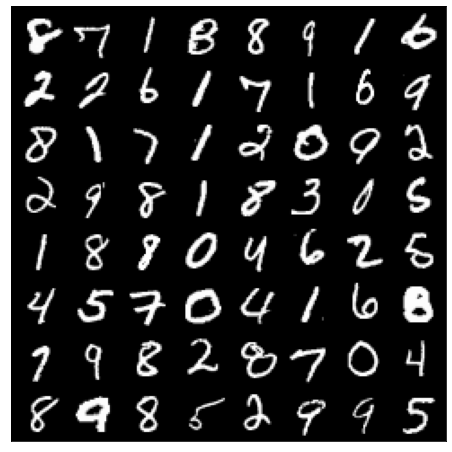

In [ ]:
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()
imshow(imgs)

In [ ]:
Z_dim = 100
H_dim = 128
X_dim = imgs.view(imgs.size(0), -1).size(1)

print(Z_dim, H_dim, X_dim)

device = 'cuda'

100 128 784


In [ ]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid()
        )
          
    def forward(self, input):
        return self.model(input)

G = Gen().to(device)

In [ ]:
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.model(input)

D = Dis().to(device)

In [ ]:
print(G)
print(D)

Gen(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Dis(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
lr = 1e-3

g_opt = opt.Adam(G.parameters(), lr=lr)
d_opt = opt.Adam(D.parameters(), lr=lr)

Epoch:0,   G_loss:4.502376843235894,    D_loss:0.16592805441032085


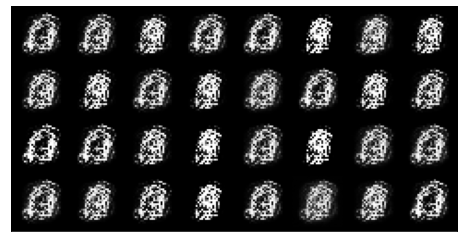

Epoch:1,   G_loss:4.660228763562022,    D_loss:0.10212166087010871


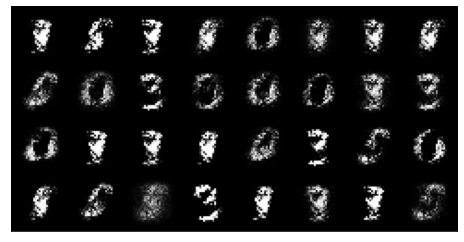

Epoch:2,   G_loss:3.6264185064128722,    D_loss:0.18850508331458196


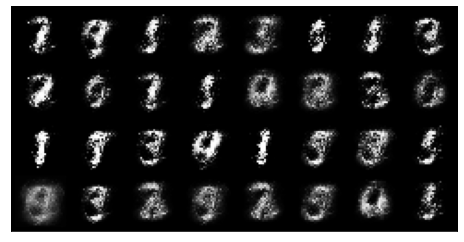

Epoch:3,   G_loss:3.8267083373913633,    D_loss:0.3680299877294345


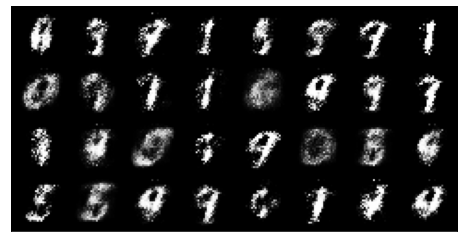

Epoch:4,   G_loss:3.2725530673445924,    D_loss:0.5692489076016555


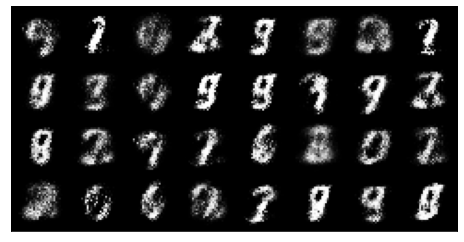

Epoch:5,   G_loss:2.9689624892877364,    D_loss:0.7254567016988421


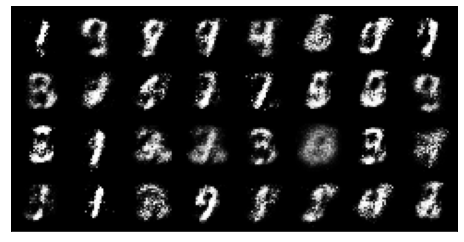

Epoch:6,   G_loss:2.67949075205748,    D_loss:0.819628565740992


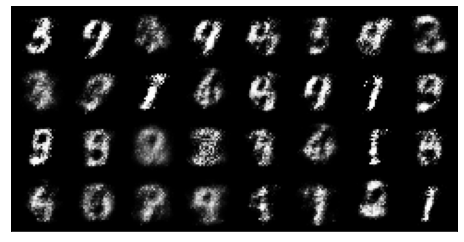

Epoch:7,   G_loss:2.364440665189137,    D_loss:0.7639210470703873


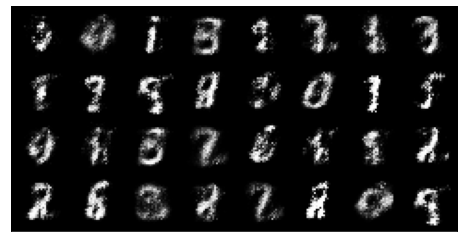

Epoch:8,   G_loss:2.233467224310202,    D_loss:0.8356079063944216


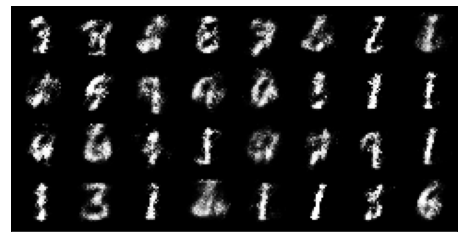

Epoch:9,   G_loss:2.258750241321287,    D_loss:0.8582393137503789


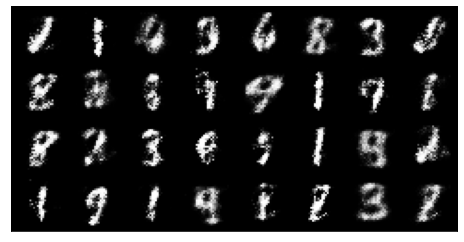

Epoch:10,   G_loss:2.165563090523677,    D_loss:0.8809351404783314


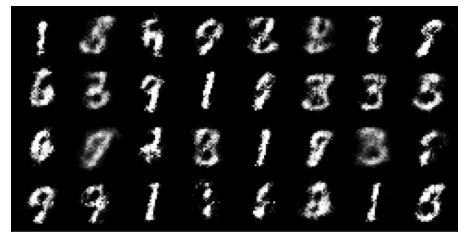

Epoch:11,   G_loss:2.125519692008175,    D_loss:0.8732168092720036


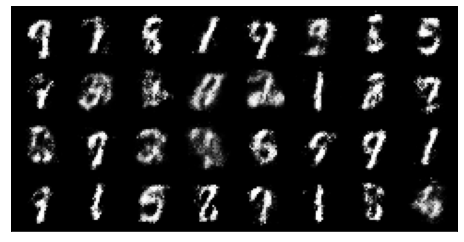

Epoch:12,   G_loss:1.9545783628024527,    D_loss:0.9320160382465005


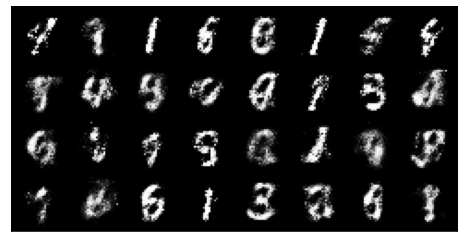

Epoch:13,   G_loss:1.9012432308085183,    D_loss:0.9145037012059551


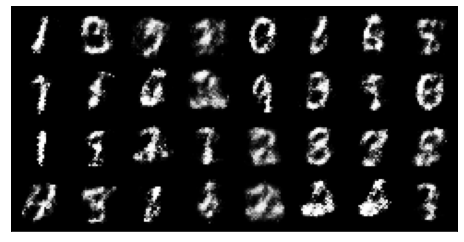

Epoch:14,   G_loss:1.840014117485933,    D_loss:0.889764201094601


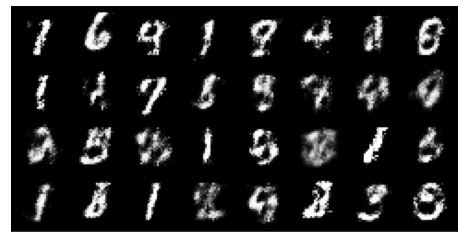

Epoch:15,   G_loss:1.9160114436515614,    D_loss:0.8925660255112882


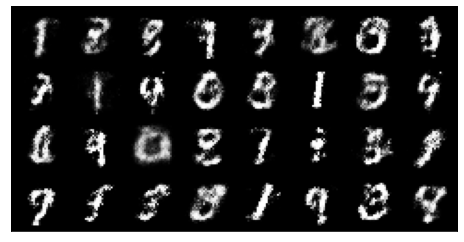

Epoch:16,   G_loss:1.8474713885453717,    D_loss:0.9427227743271825


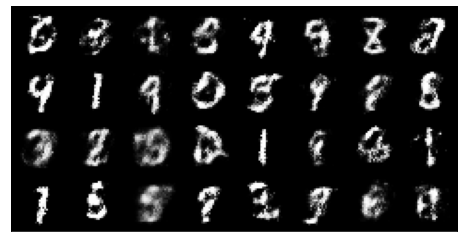

Epoch:17,   G_loss:1.6786391691866713,    D_loss:0.9852315002540027


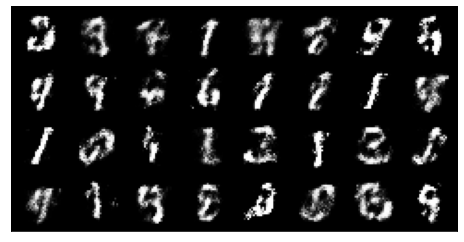

Epoch:18,   G_loss:1.6660897616130204,    D_loss:0.9656685257135932


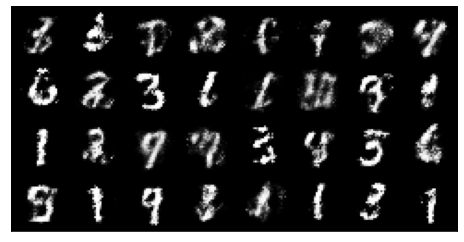

Epoch:19,   G_loss:1.63859778896832,    D_loss:0.9741546360414419


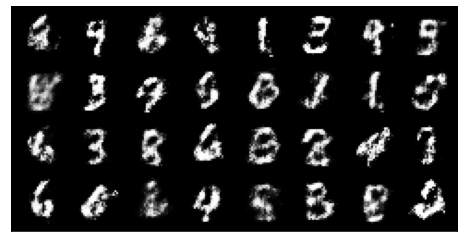

In [ ]:
for epoch in range(20):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i, data in enumerate(trainLoader):
        X, _ = data
        X = X.view(X.size(0), -1).to(device)
        mb_size = X.size(0)
        
        one_labels = torch.ones(mb_size, 1).to(device)
        zero_labels = torch.zeros(mb_size, 1).to(device)
        
        z = torch.randn(mb_size, Z_dim).to(device)
        
        D_real = D(X)
        D_fake = D(G(z))
        
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_real_loss + D_fake_loss
        
        d_opt.zero_grad()
        D_loss.backward()
        d_opt.step()
        
        z = torch.randn(mb_size, Z_dim).to(device)
        D_fake = D(G(z))
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
    
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28).cpu()
    imshow(samples)